In [1]:
import os
import gc
import pandas as pd
from tqdm.notebook import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt
import re

In [2]:
path_news = './stock/au/business_news_au/'
list_file_news = [os.path.join(path_news, filename) for filename in os.listdir(path_news) if os.path.isfile(os.path.join(path_news, filename))]

In [3]:
lm_negative = pd.read_csv('lm_negative.csv', header=None)[0].tolist()
lm_negative = {word.lower() : -1 for word in lm_negative}

lm_positive = pd.read_csv('lm_positive.csv', header=None)[0].tolist()
lm_positive = {word.lower() : 1 for word in lm_positive}

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
              "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
              "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
              "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
              "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
              "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]
    
    if word.lower() in negate:
        return True
    else:
        return False

def lm_analysis(text):
    pos_count = 0
    neg_count = 0
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())
    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in lm_negative:
            neg_count += 1

        if input_words[i] in lm_positive:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 0:
                pos_count += 1
    
    if pos_count + neg_count > 0:
        polarity = (pos_count - neg_count) / (pos_count + neg_count)
    else:
        polarity = 0
    
    subjectivity = (pos_count + neg_count) / word_count if word_count > 0 else 0
    pos_rate = pos_count / word_count if word_count > 0 else 0
    neg_rate = neg_count / word_count if word_count > 0 else 0
    
    return {'Positive' : pos_rate, 
            'Negative' : neg_rate, 
            'Polarity' : polarity, 
            'Subjectivity' : subjectivity}

def lm_sentiment_article(list_word):
#     list_word = text.replace('\t', ' ').replace('\n', ' ').split(' ')
    df_list_word = pd.DataFrame(list_word, columns=['words'])
    df_list_word['lm_analysis'] = df_list_word['words'].apply(lm_analysis)
    df_list_word['pos'] = df_list_word['lm_analysis'].apply(lambda x: x['Positive'])
    df_list_word['neg'] = df_list_word['lm_analysis'].apply(lambda x: x['Negative'])
    sum_diff = (df_list_word['pos'] - df_list_word['neg']).sum()
    if sum_diff < 0:
        return -1
    if sum_diff > 0:
        return 1
    return 0

def vader_sentiment_article(list_word):
#     list_word = text.replace('\t', ' ').replace('\n', ' ').split(' ')
    df_list_word = pd.DataFrame(list_word, columns=['words'])
    
    analyzer = SentimentIntensityAnalyzer()
    df_list_word['vader_analysis'] = df_list_word['words'].apply(analyzer.polarity_scores)
    df_list_word['pos'] = df_list_word['vader_analysis'].apply(lambda x: x['pos'])
    df_list_word['neg'] = df_list_word['vader_analysis'].apply(lambda x: x['neg'])
    
    sum_diff = (df_list_word['pos'] - df_list_word['neg']).sum()
    if sum_diff < 0:
        return -1
    if sum_diff > 0:
        return 1
    return 0

In [4]:
def make_sentiment_features(df):
    print(df.shape)
    df['article_concat_split'] = df['article_concat'].apply(lambda x: x.replace('\t', ' ').replace('\n', ' ').split(' '))
    df['vader_sentiment'] = df['article_concat_split'].apply(vader_sentiment_article)
    df['vader_sentiment_pos'] = (df['vader_sentiment'] > 0).astype('int')
    df['vader_sentiment_neg'] = (df['vader_sentiment'] < 0).astype('int')
    
    df['lm_sentiment'] = df['article_concat_split'].apply(lm_sentiment_article)
    df['lm_sentiment_pos'] = (df['lm_sentiment'] > 0).astype('int')
    df['lm_sentiment_neg'] = (df['lm_sentiment'] < 0).astype('int')
    
#     df['stock_news_vader_neg'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['neg'], axis=1)
#     df['stock_news_vader_pos'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['pos'], axis=1)
#     df['stock_news_vader_neu'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['neu'], axis=1)
#     df['stock_news_vader_compound'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['compound'], axis=1)
    
#     df['stock_news_wordnet_pos'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[0], axis=1)
#     df['stock_news_wordnet_neg'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[1], axis=1)
#     df['stock_news_wordnet_obj'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[2], axis=1)
#     df['stock_news_wordnet_total'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[3], axis=1)
    
#     df['stock_news_lm_dict'] = df.apply(lambda x: lm_analysis(x['article_concat']), axis=1)
#     df['stock_news_lm_pos'] = df.apply(lambda x: x['stock_news_lm_dict']['Positive'], axis=1)
#     df['stock_news_lm_neg'] = df.apply(lambda x: x['stock_news_lm_dict']['Negative'], axis=1)
#     df['stock_news_lm_polar'] = df.apply(lambda x: x['stock_news_lm_dict']['Polarity'], axis=1)
#     df['stock_news_lm_subject'] = df.apply(lambda x: x['stock_news_lm_dict']['Subjectivity'], axis=1)
    
#     df.drop('stock_news_lm_dict', axis=1, inplace=True)
    return df

In [5]:
def daily_sentiment_score(pos_num, neg_num):
    if pos_num > neg_num:
        return 2 * pos_num / (pos_num + neg_num) - 1
    
    if pos_num < neg_num:
        return 1 - 2  * neg_num / (pos_num + neg_num)

    return 0

In [6]:
list200asx = pd.read_csv('list_asx200.csv')['symbol'].unique().tolist()

In [7]:
df = None
filter_start_time = '2005-01-01'

for file in tqdm(list_file_news):
    basename = os.path.basename(file)
    os.path.splitext(basename)
    file_name, file_extension = os.path.splitext(basename)
    if file_extension != '.csv':
        continue
    
    if file_name not in list200asx:
        continue
    
    try:
        df_news = pd.read_csv(file)[['time', 'title_name', 'para']]
    except:
        df_news = pd.read_csv(file, header=None)
        df_news.columns = ['time', 'title_name', 'para']   
    
    df_news.loc[df_news['time'].str.contains('ago'), 'time'] = 'Aug 15, 2021'
    df_news['Date'] = pd.to_datetime(df_news['time'])
    df_news = df_news[df_news['Date'] >= filter_start_time]
    df_news.drop_duplicates(subset=['title_name'], keep='first', inplace=True)
    df_news.drop('time', axis=1, inplace=True)
    df_news['symbol'] = file_name
    df_news.rename(columns={'title_name' : 'article_title'}, inplace=True)
    df_news.rename(columns={'para' : 'article_abstract'}, inplace=True)
    df_news = df_news[['symbol', 'Date', 'article_title', 'article_abstract']]
    
    df_news[['article_title', 'article_abstract']] = df_news[['article_title', 'article_abstract']].fillna('')
    df_news['article_concat'] = df_news['article_title'] + ' ' + df_news['article_abstract']

    df_news = make_sentiment_features(df_news)
    
    if df is None:
        df = df_news.copy()
    else:
        df = pd.concat([df, df_news], axis=0)
    
    del df_news
    gc.collect()

  0%|          | 0/228 [00:00<?, ?it/s]

(334, 5)
(80, 5)
(63, 5)
(11, 5)
(358, 5)
(98, 5)
(63, 5)
(82, 5)
(86, 5)
(77, 5)
(127, 5)
(90, 5)
(581, 5)
(113, 5)
(2003, 5)
(148, 5)
(63, 5)
(487, 5)
(80, 5)
(23, 5)
(16, 5)
(61, 5)
(8, 5)
(115, 5)
(214, 5)
(52, 5)
(104, 5)
(144, 5)
(4349, 5)
(76, 5)
(51, 5)
(144, 5)
(135, 5)
(379, 5)
(31, 5)
(203, 5)
(24, 5)
(50, 5)
(2025, 5)
(60, 5)
(27, 5)
(114, 5)
(99, 5)
(44, 5)
(56, 5)
(369, 5)
(49, 5)
(90, 5)
(24, 5)
(231, 5)
(164, 5)
(92, 5)
(55, 5)
(737, 5)
(75, 5)
(82, 5)
(475, 5)
(75, 5)
(44, 5)
(72, 5)
(192, 5)
(2, 5)
(147, 5)
(11, 5)
(56, 5)
(65, 5)
(391, 5)
(21, 5)
(100, 5)
(173, 5)
(1392, 5)
(125, 5)
(95, 5)
(16, 5)
(58, 5)
(71, 5)
(233, 5)
(132, 5)
(93, 5)
(238, 5)
(21, 5)
(224, 5)
(52, 5)
(215, 5)
(157, 5)
(122, 5)
(48, 5)
(3, 5)
(126, 5)
(7, 5)
(1, 5)
(1, 5)
(94, 5)
(114, 5)
(389, 5)
(40, 5)
(138, 5)
(109, 5)
(6, 5)
(109, 5)
(181, 5)
(15, 5)
(57, 5)
(86, 5)
(857, 5)
(108, 5)
(1689, 5)
(887, 5)
(149, 5)
(78, 5)
(34, 5)
(74, 5)
(318, 5)
(120, 5)
(29, 5)
(86, 5)
(34, 5)
(208, 5)
(552,

In [8]:
df.head()

,symbol,Date,article_title,article_abstract,article_concat,article_concat_split,vader_sentiment,vader_sentiment_pos,vader_sentiment_neg,lm_sentiment,lm_sentiment_pos,lm_sentiment_neg
0,A2M,2021-05-11,Australia shares ease from record peak on tech...,May 11 (Reuters) - Australian shares on Tuesda...,Australia shares ease from record peak on tech...,"[Australia, shares, ease, from, record, peak, ...",1,1,0,-1,0,1
1,A2M,2021-05-10,"Australia, NZ dollars near 10-week highs on so...","By Swati Pandey SYDNEY, May 10 (Reuters) - The...","Australia, NZ dollars near 10-week highs on so...","[Australia,, NZ, dollars, near, 10-week, highs...",-1,0,1,-1,0,1
2,A2M,2021-05-10,Australia shares hit near 15-month peak as min...,May 10 (Reuters) - Australian shares scaled a ...,Australia shares hit near 15-month peak as min...,"[Australia, shares, hit, near, 15-month, peak,...",1,1,0,-1,0,1
3,A2M,2021-04-29,"Australian shares inch higher on gold, energy ...",By Arundhati Dutta April 29 (Reuters) - Austra...,"Australian shares inch higher on gold, energy ...","[Australian, shares, inch, higher, on, gold,, ...",1,1,0,0,0,0
4,A2M,2021-04-27,"Australia shares end lower as tech, health car...","* Tech stocks end 2.5% down, hit lowest in nea...","Australia shares end lower as tech, health car...","[Australia, shares, end, lower, as, tech,, hea...",1,1,0,-1,0,1


In [9]:
df[['symbol', 'Date', 'vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 
    'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']] \
    .to_csv('./exported_data/news_sentiment_analysis/au_stock_news_sentiment_analysis_rawdata.csv', index=False)

In [10]:
df.describe()

,vader_sentiment,vader_sentiment_pos,vader_sentiment_neg,lm_sentiment,lm_sentiment_pos,lm_sentiment_neg
count,44956.000000,44956.000000,44956.000000,44956.00000,44956.000000,44956.000000
mean,0.371319,0.580345,0.209027,-0.54778,0.001780,0.549560
std,0.807161,0.493508,0.406618,0.50128,0.042147,0.497543
min,-1.000000,0.000000,0.000000,-1.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.00000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,-1.00000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [11]:
df[['vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 
    'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']].sum(axis=0)

vader_sentiment        16693
vader_sentiment_pos    26090
vader_sentiment_neg     9397
lm_sentiment          -24626
lm_sentiment_pos          80
lm_sentiment_neg       24706
dtype: int64

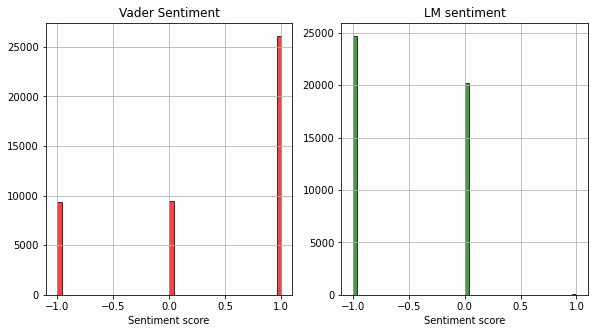

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['vader_sentiment'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Sentiment score')
plt.title('Vader Sentiment')
plt.grid(True)
plt.subplot(132)
plt.hist(df['lm_sentiment'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Sentiment score')
plt.title('LM sentiment')
# plt.grid(True)
# plt.subplot(133)
# plt.hist(pd.concat([data.compound,data.s_compound]), 
#          50, 
#          color='g',
#          edgecolor = 'black', 
#          alpha=0.75)
# plt.xlabel('Compound Score')
# plt.title('Political News and Stock News')
plt.grid(True)
plt.show()

In [9]:
df_sentiment = df.groupby(['symbol', 'Date']) \
    .agg(lm_sentiment_pos=('lm_sentiment_pos', 'sum'), 
         lm_sentiment_neg=('lm_sentiment_neg', 'sum'),
         vader_sentiment_pos=('vader_sentiment_pos', 'sum'), 
         vader_sentiment_neg=('vader_sentiment_neg', 'sum'),) \
    .reset_index()

df_sentiment['stock_daily_sentiment_score_lm'] = df_sentiment \
    .apply(lambda x: daily_sentiment_score(x['lm_sentiment_pos'], x['lm_sentiment_neg']), axis=1)
df_sentiment['stock_daily_sentiment_score_vader'] = df_sentiment \
    .apply(lambda x: daily_sentiment_score(x['vader_sentiment_pos'], x['vader_sentiment_neg']), axis=1)

df_sentiment[['symbol', 'Date', 'stock_daily_sentiment_score_lm', 'stock_daily_sentiment_score_vader']].head()

,symbol,Date,stock_daily_sentiment_score_lm,stock_daily_sentiment_score_vader
0,A2M,2018-09-27,-1.0,0.0
1,A2M,2018-10-03,-1.0,1.0
2,A2M,2018-10-04,-1.0,1.0
3,A2M,2018-10-05,-1.0,1.0
4,A2M,2018-10-08,-1.0,1.0


In [9]:
df.describe()

,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total
count,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000,288565.000000
mean,0.075769,0.118148,0.806077,0.144212,0.761158,0.626431,18.897681,0.134727
std,0.096249,0.102844,0.125081,0.515180,0.609514,0.587094,3.922670,0.777437
min,0.000000,0.000000,0.189000,-0.986700,0.000000,0.000000,0.000000,-4.375000
25%,0.000000,0.000000,0.718000,-0.226300,0.250000,0.125000,16.625000,-0.250000
50%,0.044000,0.099000,0.814000,0.202300,0.625000,0.500000,19.125000,0.125000
75%,0.129000,0.180000,0.906000,0.585900,1.125000,1.000000,21.500000,0.625000
max,0.695000,0.811000,1.000000,0.981600,6.375000,4.875000,34.000000,6.250000


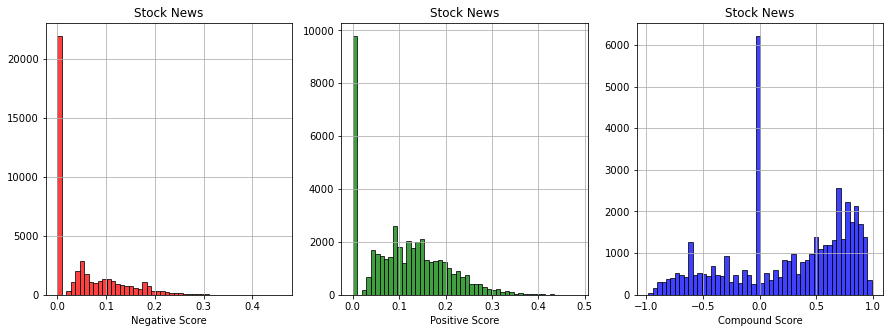

In [9]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['stock_news_vader_neg'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Negative Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(132)
plt.hist(df['stock_news_vader_pos'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Positive Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(133)
plt.hist(df['stock_news_vader_compound'], 
         50, 
         color='b',
         edgecolor = 'black', 
         alpha=0.75)
plt.xlabel('Compound Score')
plt.title('Stock News')
plt.grid(True)
plt.show()

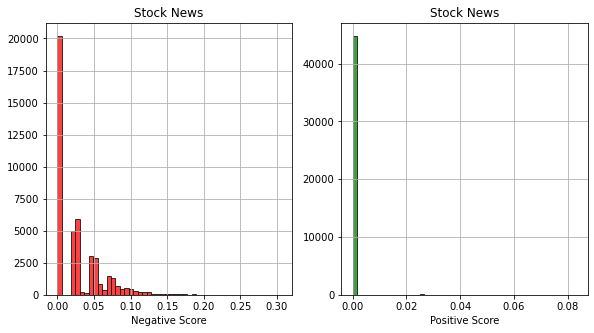

In [10]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['stock_news_lm_neg'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Negative Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(132)
plt.hist(df['stock_news_lm_pos'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Positive Score')
plt.title('Stock News')
plt.grid(True)

plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44956 entries, 0 to 98
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   symbol                     44956 non-null  object        
 1   Date                       44956 non-null  datetime64[ns]
 2   article_title              44956 non-null  object        
 3   article_abstract           44956 non-null  object        
 4   article_concat             44956 non-null  object        
 5   stock_news_vader_neg       44956 non-null  float64       
 6   stock_news_vader_pos       44956 non-null  float64       
 7   stock_news_vader_neu       44956 non-null  float64       
 8   stock_news_vader_compound  44956 non-null  float64       
 9   stock_news_lm_pos          44956 non-null  float64       
 10  stock_news_lm_neg          44956 non-null  float64       
 11  stock_news_lm_polar        44956 non-null  float64       
 12  stock_n

In [10]:
df_sentiment[['symbol', 'Date', 'stock_daily_sentiment_score_lm', 'stock_daily_sentiment_score_vader']] \
    .to_csv('./exported_data/news_sentiment_analysis/au_stock_news_sentiment_analysis.csv', index=False)